## Information Extraction Functions
#### Work in Progress

This `.ipynb` file is to hold code that has been cleaned up & ready to share with the team. This will help us conform to using the same form when storing data, etc. 

It also contains useful code snippets that we feel other team members may find useful when they are working on their own.

In [43]:
from collections import defaultdict, Counter
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, classification_report

import numpy as np
from nltk import sent_tokenize
from nltk.corpus import stopwords
from itertools import chain

#### Rule-Based Information Parsing

Main function for rule based parsing.

The following function will call all others as needed.

In [44]:
def rule_based_parse_BCJ(path, damage_model = None, damage_vectorizer = None):
    '''Given file path (text file) of negligence cases, finds static 
    information within the case (information that can be pattern matched)
    Expects a B.C.J. case format (British Columbia Judgments)
    
    The following fields are currently implemented:
    - Case Title
    - Judge Name
    - Registry
    - Year
    - Decision Length (in paragraphs)
    - Damages
    - Multiple Defendants
    - Plaintiff Wins
    
    Arguments: 
    doc (String): The case in text format following the form used in the DOCX to TXT notebook
    [Optional] damage_model (sklearn model) - Used for damage classification. If not supplied uses rule based
    [Optional] damage_vectorizer (DictVectorizer) Used for damage classification. If not supplied uses rule based
    
    Returns: case_parsed_data (list) of case_dict (Dictionary): List of Dictionaries with rule based parsable fields filled in
    '''
    with open(path, encoding='utf-8') as document:
        document_data = document.read()
        
    document_data = document_data.split('End of Document\n') # Always split on 'End of Document\n'
    case_parsed_data = []
    for i in range(len(document_data)):
        case_dict = dict() 
        case = document_data[i]
        case = case.strip() # Make sure to strip!
        if len(case) == 0: # Skip empty lines
            continue
        
        lines = case.split('\n')
        if len(lines) < 2:
            print(case)
        case_title = lines[0]
        case_type = lines[1]

        if filter_unwanted_cases(case, case_title, case_type):
            # Fields that can be found via pattern matching
            if re.search('contributory negligence', case, re.IGNORECASE):
                contributory_negligence_raised = True
            else:
                contributory_negligence_raised = False
            case_number = re.search(r'\/P([0-9]+)\.txt', path).group(1)
            decision_len = re.search(r'\(([0-9]+) paras\.?\)', case) # e.g.) (100 paras.)
            registry = re.search(r'(Registry|Registries): ?([A-Za-z0-9 ]+)', case) # e.g.) Registry: Vancouver
            written_decision = True if int(decision_len.group(1)) > 1 else False
            if registry:
                registry = registry.group(2).strip()
            else:
                registry = re.search(r'([A-Za-z ]+) Registry No.', case) # Alt form e.g.) Vancouver Registory No. XXX
                if registry:
                    registry = registry.group(1).strip()
                else:
                    registry = re.search(r'([A-Za-z ]+) No. S[0-9]*', case)
                    if registry:
                        registry = registry.group(1).strip()
                    else:
                        print('WARNING: Registry could not be found (This shouldn\'t occur!)')
            # Fields that are always in the same place
            judge_name = lines[4].strip()
            case_title = lines[0].strip()
            # Extract year from case_title (in case we want to make visualizations, etc.)
            year = re.search(r'20[0-2][0-9]', case_title) # Limit regex to be from 2000 to 2029
            if year:
                year = year.group(0)
            else:
                # Rare case: Sometimes the title is too long. Rely on Heard date.
                year = re.search(r'Heard:.* ([2][0][0-2][0-9])', case)
                if year:
                    year = year.group(1)
                else:
                    print('WARNING: Year not found')
            case_dict['case_number'] = '%s of %s'%(i+1+((int(case_number)-1)*50), case_number)
            case_dict['case_title'] = case_title
            case_dict['year'] = year
            case_dict['registry'] = registry
            case_dict['judge'] = judge_name
            case_dict['decision_length'] = decision_len.group(1)
            case_dict['multiple_defendants'] = rule_based_multiple_defendants_parse(case)
            case_dict['contributory_negligence_raised'] = contributory_negligence_raised
            case_dict['written_decision'] = written_decision
            
            case_dict['plaintiff_wins'] = plaintiff_wins(case)
                        
            if damage_model and damage_vectorizer:
                predictions = predict(case, damage_model, damage_vectorizer)
                case_dict['damages'] = assign_classification_damages(predictions)
            else:
                case_dict['damages'] = rule_based_damage_extraction(case)
            
            
            percent_reduction, contributory_negligence_successful = get_percent_reduction_and_contributory_negligence_success(case_dict, case)
            case_dict['percent_reduction'] = percent_reduction
            case_dict['contributory_negligence_successful'] = contributory_negligence_successful
             
        
        # don't add empty dictionaries (non BCJ cases) to list
        if case_dict != dict(): 
            case_parsed_data.append(case_dict)
    return case_parsed_data

In [45]:
def rule_based_multiple_defendants_parse(doc):
    ''' Helper function for rule_based_parse_BCJ
    
    Given a case. Uses regex/pattern-matching to determine whether we have multiple defendants.
    For the most part the logic relies on whether the langauge used implies plurality or not.
    
    Arguments: doc (String): The case in text format following the form used in the DOCX to TXT notebook
    Returns: response (String, 'Y', 'N', or 'UNK')
    '''

    # Case 1)
    # Traditional/most common. Of form "Between A, B, C, Plaintiff(s), X, Y, Z Defendant(s)"
    # Will also allow "IN THE MATTER OF ... Plaintiff .... Defendant..."
    # Can successfully cover ~98% of data
    regex_between_plaintiff_claimant = re.search(r'([Between|IN THE MATTER OF].*([P|p]laintiff[s]?|[C|c]laimant[s]?|[A|a]ppellant[s]?|[P|p]etitioner[s]?|[R|r]espondent[s]?).*([D|d]efendant[s]?|[R|r]espondent[s]?|[A|a]pplicant[s]?).*\n)', doc)
    
    # Match found
    if regex_between_plaintiff_claimant:
        text = regex_between_plaintiff_claimant.group(0).lower()
        if 'defendants' in text or 'respondents' in text or 'applicants' in text: # Defendant/respondent same thing.
            return 'Y'
        elif 'defendant' in text or 'respondent' in text or 'applicant' in text:
            return 'N'
    
    # If not found, try other less common cases
    else:
        # Case 2)
        # Sometimes it does not mention the name of the second item. (Defendent/Respondent)
        # We can estimate if there are multiple based on the number of "," in the line (Covers all cases in initial data)
        regex_missing_defendent = re.search(r'(Between.*([P|p]laintiff[s]?|[C|c]laimant[s]?|[A|a]ppellant[s]?|[P|p]etitioner[s]?).*\n)', doc)
        if regex_missing_defendent:
            text = regex_missing_defendent.group(0).lower()
            if len(text.split(',')) > 5:
                return 'Y'
            else:
                return 'N'
            
        else:
            print('Multiple defendants: Unknown! Unable to regex match')
            return 'UNK'
        
        

In [46]:
def rule_based_damage_extraction(doc, min_score = 0.9, max_match_len_split = 10):
    '''Helper function for rule_based_parse_BCJ
    
    Given a case, attempts to extract damages using regex patterns
    
    Arguments: doc (String): The case in text format following the form used in the DOCX to TXT notebook
    min_score (float): The minimum paragraph score to consider having a valid $ number
                       Paragraph has score 1 if its the last paragraph
                       Paragraph has score 0 if its the first paragraph
    max_match_len_split (int): The max amount of items that can appear in a regex match after splitting (no. words)
    
    Returns: damages (Dict): Contains any found damages
    
    '''
    damages = defaultdict(float)
    repetition_detection = defaultdict(set) # try to stem the repeated values
    no_paras = re.search(r'\(([0-9|,]+) paras?\.?\)', doc).group(1) # Get number of paragraphs
    pattern = r'([.]?)(?=\n[0-9]{1,%s}[\xa0|\s| ]{2})'%len(no_paras) # Used to split into paras
    paras_split = re.split(pattern, doc)
    money_patt = r'\$[0-9|,]+' # Used to get all paragraphs with a money amount
    scored_paras = [] # Score paragraphs based on where they appear in the document
                      # Score of 0.0 would be the first paragraph. Score of 1.0 would be the last paragraph
        
    for i, paragraph in enumerate(paras_split):
        if re.search(money_patt, paragraph):
            scored_paras.append((i / len(paras_split), paragraph)) # (score, paragraph). Score formula: i/no_paras
            
    scored_paras = sorted(scored_paras, key=lambda x:x[0])[::-1] # Store from last paragraph to first
    if len(scored_paras) == 0:
        return None
    if scored_paras[0][0] < min_score: #If highest scored paragraph is less than minimum score.
        return None
    
    # Rule based dmg extraction REGEX patterns
    regex_damages = r'[\w|-]* ?(?:damage|loss|capacity|cost).+?\$? ?[0-9][0-9|,|.]+[0-9]'
    #regex_damages = r'(?:[\w|-]* ?){0,3}(?:damage|loss|capacity|cost).+?\$? ?[0-9][0-9|,|.]+[0-9]'
    #regex_in_trust = r'(?:in-?trust|award).*?\$? ?[0-9][0-9|,|.]+[0-9]'
    #regex_damages = r'(?![and])(?:[\w|-]* ?){0,2} ?(?:damage|loss|capacity|cost).+?\$? ?[0-9][0-9|,|.]+[0-9]'
    regex_damages_2 = r'[^:] \$? ?[0-9][0-9|,|.]+[0-9] (?:for|representing)?[ \w\-+]+damages?'
    regex_damages_3 = r'[^:] \$? ?[0-9][0-9|,|.]+[0-9] (?:for|representing)?[ \w\-+]+damages?(?:(?:for|representing)?.*?[;.\n])'
    regex_future_care_loss = r'(?:future|past|in[-| ]?trust|award).*?(?:loss|costs?|income|care)?.*?\$? ?[0-9][0-9|,|.]+[0-9]'
    regex_for_cost_of = r'\$? ?[0-9][0-9|,|.]+[0-9][\w ]*? cost .*?\.'

    # Keywords to look in match for categorization
    general_damage_keywords = [('general',), ('future', 'income', 'loss'), ('future', 'income'), ('future', 'wage', 'loss'), ('future', 'earning'), ('!past', 'earning', 'capacity'), ('future', 'capacity'), ('future', 'earning'), ('!past', 'loss', 'opportunity'), ('!past', 'loss', 'housekeep'), ('ei', 'benefit')]
    special_damage_keywords = [('special',), ('trust',), ('past', 'income', 'loss'), ('past', 'wage'), ('past', 'earning'), ('past', 'income'), ('earning', 'capacity')]
    aggravated_damage_keywords = [('aggravated',)]
    non_pecuniary_damage_keywords = [('non', 'pecuniary')]
    punitive_damage_keywords = [('punitive',)]
    future_care_damage_keywords = [('future', 'care'), ('future', 'cost')]
    
    patterns = [regex_damages, regex_damages_2, regex_damages_3, regex_future_care_loss, regex_for_cost_of]
    banned_words = ['seek', 'claim', 'propose', 'range', ' v. '] # Skip paragraphs containing these
    counter_words = ['summary', 'dismissed'] # Unless these are mentioned. 
                                             # example) "Special damage is $5k. But claims for aggravated are 'dismissed'" 
    
    # Get money mounts from the text
    total = None
    matches = []
    summary_matches = []
    for i, scored_para in enumerate(scored_paras):
        text = scored_para[1]
        score = scored_para[0]
        
        if score > min_score:
            if any(item.startswith('summary') for item in text.lower().split()[:4]) or any(item.startswith('conclusion') for item in text.lower().split()[:4]):
                text_matches = get_matching_text(patterns, text, max_match_len_split)
                for t_m in text_matches:
                    summary_matches.append((score, t_m))
            elif i+1 < len(scored_paras) and (any(item.startswith('summary') for item in scored_paras[i+1][1].lower().split()[-4:]) or any(item.startswith('conclusion') for item in scored_paras[i+1][1].lower().split()[-4:])):
                text_matches = get_matching_text(patterns, text, max_match_len_split)
                for t_m in text_matches:
                    summary_matches.append((score, t_m))
            else:
                skip = False # Skip paras with banned words
                for banned_word in banned_words: 
                    if banned_word in text:
                        skip = True       
                for counter_word in counter_words:
                    if counter_word in text:
                        skip = False
                if skip:
                    continue

                text_matches = get_matching_text(patterns, text, max_match_len_split)
                for t_m in text_matches:
                    matches.append((score, t_m))
        
    # Only keep matches from the summary if a summary was found. If not keep all matches.
    if len(summary_matches) > 0: 
        matches = summary_matches

    # Extract $ value. Determine correct column
    regex_number_extraction = r' ?[0-9][0-9|,|.]+[0-9]'
    for score, match in matches:
        skip = False # Banned words should not appear in final matches
        for banned_word in banned_words: 
            if banned_word in match:    
                skip = True
                break
        if skip:
            continue
        
        amount = re.findall(regex_number_extraction, match, re.IGNORECASE)
        extracted_value = clean_money_amount(amount)
        if extracted_value is None: # Make sure we are able to extract a value
            continue
            
        value_mapped = False # If we mapped the value into a damage category - stop trying to map into other categories
        value_mapped = assign_damage_to_category(extracted_value, general_damage_keywords, match, score, matches, 'General', damages, repetition_detection, repetition_key = ('general',))
        if not value_mapped:
            value_mapped = assign_damage_to_category(extracted_value, special_damage_keywords, match, score, matches, 'Special', damages, repetition_detection, repetition_key = ('special',))
        if not value_mapped:
            value_mapped = assign_damage_to_category(extracted_value, non_pecuniary_damage_keywords, match, score, matches, 'Non-pecuniary', damages, repetition_detection, repetition_key = ('non','pecuniary'))
        if not value_mapped:
            value_mapped = assign_damage_to_category(extracted_value, aggravated_damage_keywords, match, score, matches, 'Aggravated', damages, repetition_detection, repetition_key = ('aggravated',))
        if not value_mapped:
            value_mapped = assign_damage_to_category(extracted_value, punitive_damage_keywords, match, score, matches, 'Punitive', damages, repetition_detection, repetition_key = ('punitive',))
        if not value_mapped:
            value_mapped = assign_damage_to_category(extracted_value, future_care_damage_keywords, match, score, matches, 'Future Care', damages, repetition_detection) 
        if not value_mapped: # Last attempt: Only use "total amounts" if nothing else was found
            total_keywords = [('total',), ('sum',), ('award',)]
            for keywords in total_keywords:
                if match_contains_words(match.lower(), keywords):
                    if is_best_score(score, matches, keywords):
                        if extracted_value not in repetition_detection[('total',)]:
                            damages['Pecuniary Total'] = damages['Special'] + damages['General'] + damages['Punitive'] + damages['Aggravated'] + damages['Future Care']
                            damages['Total'] = damages['Pecuniary Total'] + damages['Non-pecuniary']
                            if damages['Total'] == 0:
                                total = extracted_value
                                repetition_detection[('total',)].add(extracted_value)
                        
    damages['Pecuniary Total'] = damages['Special'] + damages['General'] + damages['Punitive'] + damages['Aggravated'] + damages['Future Care']
    damages['Total'] = damages['Pecuniary Total'] + damages['Non-pecuniary']
    
    if damages['Total'] == 0 and total is not None: # Only use the "total" if we couldnt find anything else!
        damages['Total'] = total
        damages['General'] = total
        
    columns = ['Total', 'Pecuniary Total', 'Non-pecuniary', 'Special', 'General', 'Punitive', 'Aggravated', 'Future Care']
    for c in columns:
        damages[c] = None if damages[c] == 0 else damages[c]
    
    return damages

def assign_damage_to_category(damage, damage_keywords, match, match_score, matches, damage_type, damage_dict, repetition_dict, repetition_key = None):
    '''Helper function for rule based damage extraction.
    
    Adds damage to dictionary based on given parameters so long as it is the
    highest scoring match & doesn't appear in the repetition dictionary
    
    Argumets:
    damage (float) - The damage amount in the match
    damage_keywords (list) - Keywords that may appear in match
    match (string) - The match string itself
    matches (list) - All matches. Used to determine if we found the best match
    damage_dict (dict) - Dictionary storing all damages
                       - Will be modified in place
    repetition_dict (dict) - Dictionary storing repeated values
                           - Will be modified in place
    (Optional) repetition_key (Tuple) - If not none, will use this key to store repetitions. Else will use matching keyword
    
    Returns:
    value_belongs (Boolean) - True if the value belongs in the given keyword category. False otherwise
    '''
    match = match.lower()
    value_belongs = False
    
    for keywords in damage_keywords:
        if match_contains_words(match, keywords):
            value_belongs = True
            if is_best_score(match_score, matches, keywords):
                if damage not in repetition_dict[repetition_key if repetition_key else keywords]:
                    damage_dict[damage_type] += damage
                    repetition_dict[repetition_key if repetition_key else keywords].add(damage)
            break
    
    return value_belongs

def clean_money_amount(money_regex_match):
    '''Helper function for rule based damage extraction.
    
    Arguments:
    money_regex_match (Regex.findall object) - Match of $ amount
    
    Returns:
    None if a bad match
    extracted_value (float) - The money amount in float form
    '''
    # If our regex contains more than 1 or 0 money values. We cannot use the match.
    if len(money_regex_match) > 1:
        return None
    if len(money_regex_match) == 0:
        print('Error: No Money in match!', match)
        return None

    extracted_value = None
    amount = money_regex_match[0].replace(',' , '')
    amount = amount.replace(' ' , '')
    # Deals with money at end of sentence. example) ... for '5,000.00.' -> '5000.00'
    if amount[-1] == '.': 
        amount = amount[:-1]
    # Deals with quantities such as $2.5 million
    if 'million' in amount or amount[-1] == 'm':
        amount = str(float(re.findall('[0-9|\.]+', amount)[0])*10e6)
    # Deals with a rare typo in some cases. example) 50.000.00 -> 50000.00
    if amount.count('.') > 1: 
        dot_count = amount.count('.')
        changes_made = 0
        new_amount = ''
        for letter in amount:
            if letter == '.' and changes_made != dot_count-1:
                changes_made += 1
            else:
                new_amount += letter
        amount = new_amount
    extracted_value = float(amount)
    return extracted_value

def get_matching_text(patterns, text, max_match_len_split):
    '''Helper function for rule based damage extraction.
    
    Given a set of regex; pulls out all matching text
    
    Arguments:
    patterns (list) - List of regex patterns in string format
    text (string) - Text to search for matches in
    
    Returns:
    matches (list) - List containing all matches in text format
    '''

    matches = []
    for pattern in patterns:
        for match in re.findall(pattern, text, re.IGNORECASE):
            if 'and' not in match:
                if len(match.split()) <= max_match_len_split:
                    matches.append(match)
                    
    return matches

def is_best_score(score, matches, keywords):
    '''Helper function for rule based damage extraction.
    
    Given a set of regex matches, determine if the score is the highest score out of all matches for the given keywords
    Score is from 0 - 1; describes where in the paragraph the match was found
    Score is 1 if the match came from the final paragraph
    Score is 0 if the match came from the first paragraph
    
    Arguments:
    score (float) - The score of the item you're inspecting
    matches (list) - List of matches where each element is of form (score, match text)
    keywords (tuple) - All words that should appear in the match
    
    Returns: True or False
    
    '''
    best_score = score
    
    for score, match in matches:
        if all(word in match.lower() for word in keywords):
            if score > best_score:
                return False
            
    return True

def match_contains_words(match, words):
    '''Helper function for rule based damage extraction.
    
    Given some text. Find if the words are all present in the text.
    If word begins with '!' the word cannot appear in the text, acts as a negation. 
    Can handle mix/matching of both types.
    
    Example: ('!good', 'day') would match any string with the word "day" present and "good" NOT present.
    
    Arguments:
    match (String) - The text to look for words in
    words (list) - List of words to check for. If word begins with ! (i.e. '!past'), then the word cannot appear in it
    
    Returns:
    True if all words are present (or not present if using !)
    False otherwise
    
    '''
    pos_words = []
    neg_words = []
    for word in words:
        if word.startswith('!'):
            neg_words.append(word[1:])
        else:
            pos_words.append(word)
            
    if all(word in match for word in pos_words):
        if all(word not in match for word in neg_words):
            return True
        
    return False

def filter_unwanted_cases(case, case_title, case_type):
    '''Given a case, its title & type, determines whether the case
    is relevant or not for our analysis
    
    Removes crown cases 'R.v.'
    Removes '(Re)' cases
    Removes client-solicitor cases
    Removes IN THE MATTER OF cases where plaintiff/defendant is not mentioned
    Removes non 'British Columbia Judgments' cases
    
    Arguments:
    case (string) - Case data in string form
    case_title (string) - Case title (line 1 of case)
    case_type (string) - Case type (line 2 of case)
    
    Returns:
    boolean - True if case should be analyzed. False if it should be skipped.
    '''
    
    if 'R. v.' in case_title or '(Re)' in case_title: # Skip crown cases, Skip (Re) cases
        return False

    # Skip client/solicitor cases (not same as plaintiff/defendant)
    regex_client_solicitor = re.search(r'(Between.*([C|c]lient[s]?).*([S|s]olicitor[s]?|[L|l]awyer[s]?))', case)
    if regex_client_solicitor:
        return False

    regex_solicitor_client = re.search(r'(Between.*([L|l]awyer[s]?|[S|s]olicitor[s]?).*([C|c]lient[s]?))', case)
    if regex_solicitor_client:
        return False

    # In some rare cases we have 'IN THE MATTER OF ..' (rather than 'Between ...') .. but it is following by the normal
    # plaintiff/defendant dynamic. Only skip cases if there is no mention of the following terms
    # (Can be cleaned up in future)
    key_words = ['appellant', 'respondent', 'claimant', 'petitioner', 'plaintiff', 'defendant',
    'appellants', 'respondents', 'claimants', 'petitioners', 'plaintiffs', 'defendants']
    regex_in_matter_of = re.search(r'IN THE MATTER OF .*\n\([0-9]+ paras.\)', case)
    if regex_in_matter_of:
        remove = True
        for key in key_words:
            if key in regex_in_matter_of.group(0).lower().strip():
                remove = False

        if remove:
            return False

    if 'British Columbia Judgments' in case_type:
        return True
    
    return False

### Functions Related to Contributory Negligence Extraction

In [47]:
def paragraph_tokenize(case):
    ''' Takes string input the of wntire document (case) and returns list of lists of paragraphs in the document.
    ---------
    Input: case (str) - string of single legal case
    Return: case_data(list) - list of of numbrered paragraphs in the document where the first item is the case_title'''
    
    case_data = []
    lines = case.split('\n')
    if not 'British Columbia Judgments' in lines[1]:
        return
    case_data.append(lines[0])
    decision_length = re.search(r'\(([0-9|,]+) paras?\.?\)', case).group(1)

    # split paragraphs on newline, paragraph number, two spaces
    pattern = r'.?(?=\n[0-9]{1,%s}[\xa0]{2})'%len(decision_length)
    paras_split = re.split(pattern, case)

    paras = []
    for para in paras_split:   
        # make sure the paragraph starts with the correct characters
        para_start = re.match(r'^\n([0-9]{1,%s})[\xa0]{2}'%len(decision_length), para)
        if para_start:
            paras.append(para)
    case_data.extend(paras)
    return case_data

def summary_tokenize(case):
    ''' String of Entire Document and returns the document summary and HELD section.
    ---------
    Input: case (str) - string of single legal case
    Return: summary - summary and HELD section of case (str)'''
    
    lines = case.split('\n')
    if not 'British Columbia Judgments' in lines[1]:
        return
    
    # split paragraphs on newline, paragraph number, two spaces
    summary = re.search(r'\([0-9]{1,3} paras\.\)\ncase summary\n((.*\n+?)+)(?=HELD|(Statutes, Regulations and Rules Cited:)|(Counsel\n))', case, re.IGNORECASE)
    if summary:
        summary = summary.group(1)
    else:
        return None

    return summary

def get_context_and_float(value, text, context_length = 8, plaintiff_name = 'Plaintiff', defendant_name = 'Defendant'):
    '''Given a string value found in a body of text, 
    return its context, and its float equivalent.
    -----------------
    Arguments:
    value - percent match found in text
    text - string value where matches were extracted from, eg paragraph or summary (str)
    context_length - the length of context around each quantity to return
    Rerturn:
    value_context - string of context around value (str)
    extracted_value - string quantity value extracted to its float equivalent'''
    
    
    # get context for monetary/percent values 
    context = ''
    amount = re.findall(r'[0-9]+[0-9|,]*(?:\.[0-9]+)?', value)
    extracted_value = clean_money_amount(amount) #use helper function to get float of dollar/percent value
    if not extracted_value:
        print('ERROR: cant convert string, %s'%value)
        return context, None
    # get indices of last instance of value in text - tokenize like this for values of type 'per cent and percent'
    start_idx = text.rfind(value)
    if start_idx == -1:
        print('ERROR: value not in text')
    end_idx = start_idx + len(value)
    tokens = text[:start_idx].split() + [value] + text[end_idx:].split()
    
    # get indices of quantity value in text
    loc = [i for i, token in enumerate(tokens) if value in token] 
    
    # if the quantity is in the text, choose context of last mention of value
    if len(loc) > 0:
        loc = loc[-1] 
        if loc - context_length >= 0 and loc + context_length < len(tokens):
            context = " ".join(tokens[loc - context_length:loc + context_length + 1])
        elif loc - context_length < 0 and loc + context_length < len(tokens):
            beg = abs(loc -context_length)
            context = " ".join(tokens[loc-context_length + beg:loc + context_length + 1])
        elif loc - context_length > 0 and loc + context_length > len(tokens): 
            context = " ".join(tokens[loc - context_length:len(tokens)])

    return context.lower(), extracted_value

def conditions_for_extracted_value(context, extracted_value, keywords, plaintiff_split, defendant_split, entities):
    ''' Given the context surrounding an extracted value (percent), keywords relevant to contributory negligence (ie liability, approtion, fault, etc), 
    a list of the Plaintiffs names (ie John Doe), a list of the defendants names, and a combined list of entities(ie plaintiff, john, doe, defendant):
    Return: the modifed extracted value (float)
    ------------
    Arugments:
    context: (str)
    extracted_value: (float) found in context
    keywords, plaintiff_split, defendant_split, entities: (list) of strings
    ------------
    Example:
    context = 'the defendant is responsible for 30% of damages'
    extracted_value = 30.0
    keywords = ['fault', 'liable', 'liability', 'apportion', 'contributor', 'recover', 'responsible']
    plaintiff_split = ['john', 'doe']
    defendant_split = ['jane', 'smith']
    entities = ['plaintiff', 'defendant', 'john', 'jane', 'doe', 'smith']
    conditions_for_extracted_value(context, extracted_value, 
                        keywords, plaintiff_split, defendant_split) = 70.0
    '''
    # conditions for keeping extracted_value and updating extracted_value
    # skip extracted_values with contexts lacking keywords/entities
    if extracted_value == 100 or extracted_value == 0 or extracted_value < 10:
        return
    if not any(token in context for token in keywords + entities) or context == '' or any('costs' == token for token in context.split()) or ('interest' in context and 'rate' in context.split()):
        return 
    if 'recover' in context and any(word in context for word in plaintiff_split + ['plaintiff']):
        extracted_value = 100 - extracted_value
    if any(word1 in context and word2 in context for word1 in defendant_split + ['defendant'] for word2 in ['liable', 'responsible', 'fault', 'against']):
        extracted_value = 100 - extracted_value
    return extracted_value

def contributory_negligence_successful_fun(context, keywords):
    '''Given text containing percent reduction and a list of keywords to check for,
    confirm presence of keywords and return whether or not contributory negligence was successful
    --------------
    Arguments:
    context (str)
    keywords(list)
    Returns: True or None (bool)'''
    if any(word in context for word in keywords):
        if 'plaintiff' or 'damages' or 'defendant' in context:
            contributory_negligence_successful = True
            return contributory_negligence_successful
    return

def get_percent_reduction_and_contributory_negligence_success(case_dict, case, min_score = 0.9):
    paragraphs = paragraph_tokenize(case)
    case_title = case_dict['case_title']
    assert paragraphs[0] == case_title
    
    # default value for contributory negligence success is FALSE
    contributory_negligence_successful = False
    percent_pattern = r'([0-9][0-9|\.]*(?:%|\sper\s?cent))'
    
    # entities and keywords used to filter percent values
    keywords = ['against', 'reduce', 'liability', 'liable', 'contributor', 'fault', 'apportion', 'recover', 'responsible']
    # extract plaintiff and defendant name for use in %reduction conditions
    plaintiff_defendant_pattern = r'([A-Za-z|-|\.]+(:? \(.*\))?)+ v\. ([A-Za-z|-]+)+' # group 1 is plaintiff group 2 is defendant
    if re.search(plaintiff_defendant_pattern, case_title):
        plaitiff_defendant = re.search(plaintiff_defendant_pattern, case_title).groups() # tuple (plaintiff, defendant)
    else:
        plaitiff_defendant = ('Plaintiff', 'Defendant')
    plaintiff_split = [word.lower() for word in plaitiff_defendant[0].split()]
    defendant_split = [word.lower() for word in plaitiff_defendant[-1].split()]
    entities = ['defendant', 'plaintiff'] + plaintiff_split + defendant_split 

    if case_dict['contributory_negligence_raised'] and case_dict['plaintiff_wins']:
        percent_reduction = None
        best_percent = None
        best_score = 0
        for j, paragraph in enumerate(paragraphs[1:]):
            score = float((j+1)/int(case_dict['decision_length']))
            paragraph = paragraph.lower()
            if not score >= min_score: ## min score not existant in bcj parser
                continue

            percent_mentioned = re.findall(percent_pattern, paragraph, re.IGNORECASE)
            extracted_value_tie_breaker = Counter()
            if len(percent_mentioned) > 0:
                for percent in percent_mentioned:
                    context, extracted_value = get_context_and_float(percent, paragraph)
                    # conditions for keeping extracted_value and updating extracted_value
                    # skip extracted_values with contexts lacking keywords/entities
                    if context == '':
                        continue
                    extracted_value = conditions_for_extracted_value(context, extracted_value, keywords, plaintiff_split, defendant_split, entities)
                    if not extracted_value:
                        continue
                        
                    extracted_value_tie_breaker.update([extracted_value])
                
                    # conditions for contributory negligence successful
                    if not contributory_negligence_successful and extracted_value:
                        contributory_negligence_successful = contributory_negligence_successful_fun(context, keywords)

                    # matches patter "PERCENT against plaintiff"
                    if ('against' in context or 'fault' in context) and any(plaintiff_word in context for plaintiff_word in plaintiff_split+['plaintiff']):
                        best_percent = extracted_value
                        best_score = score
                        break                    
                    
                    # choose most common percent mentioned in highest scoring paragraph
                    if extracted_value_tie_breaker != Counter():
                        if score > best_score:
                            best_score = score
                            best_percent = extracted_value_tie_breaker.most_common(1)[0][0]

             # if no percent found, check for equal apportionment
            else:
                equal_apportionment = re.findall(r'.{20} (?:liability|fault) [a-zA-Z]{1,3} apportione?d? equally .{20}', paragraph)
                if len(equal_apportionment) > 0:
                    if contributory_negligence_successful_fun(equal_apportionment[0], keywords):
                        best_percent = 50.0
                        contributory_negligence_successful = True
        
        if best_score == 0 or not best_percent or not contributory_negligence_successful:
            # no percents found in paragraphs - time to check summary - same process
            summary = summary_tokenize(case)
            if summary:
                summary = summary.lower()
                percent_mentioned = re.findall(percent_pattern, summary, re.IGNORECASE)
                extracted_value_tie_breaker = Counter()
                if len(percent_mentioned) > 0:
                    for percent in percent_mentioned:
                        context, extracted_value = get_context_and_float(percent, summary)
                        # conditions for keeping extracted_value and updating extracted_value
                        # skip extracted_values with contexts lacking keywords/entities
                        extracted_value = conditions_for_extracted_value(context, extracted_value, keywords, plaintiff_split, defendant_split, entities)
                        if not extracted_value:
                            continue
                        extracted_value_tie_breaker.update([extracted_value])
                                                   
                        # conditions for contributory negligence successful
                        if not contributory_negligence_successful and extracted_value:
                            contributory_negligence_successful = contributory_negligence_successful_fun(context, keywords) 
                            
                        # matches patter "PERCENT against plaintiff"
                        if ('against' in context or 'fault' in context) and any(plaintiff_word in context for plaintiff_word in plaintiff_split+['plaintiff']):
                            best_percent = extracted_value
                            best_score = score
                            break 
                        # choose most common percent mentioned in summary
                        if extracted_value_tie_breaker != Counter():
                            best_percent = extracted_value_tie_breaker.most_common(1)[0][0]

               # if no percent found, check for equal apportionment
                else:
                    equal_apportionment = re.findall(r'.{20} (?:liability|fault) [a-zA-Z]{1,3} apportione?d? equally .{20}', summary)
                    if len(equal_apportionment) > 0:
                        if contributory_negligence_successful_fun(equal_apportionment[0], keywords):
                            best_percent = 50.0
                            contributory_negligence_successful = True
        if contributory_negligence_successful:
            percent_reduction = best_percent
    else:
        percent_reduction = None
 
    return percent_reduction, contributory_negligence_successful

### Classification Functions

In [49]:
def train_classifier(path, clf = MultinomialNB()):
    '''Trains a classifier based on the given training data path
    
    Arguments:
    path (String) - Path to .txt containing training data
    clf - untrained sklearn classifier, ie MultinomialNB()
    
    Returns:
    model (sklearn model) - Trained model
    vectorizer (sklearn DictVectorizer) - fit-transformed vectorizer
    '''
    tag_extractor = re.compile('''<damage type ?= ?['"](.*?)['"]> ?(\$?.*?) ?<\/damage>''')
    CN_tag_extractor = re.compile('''<percentage type ?= ?['"](.*?)['"]> ?(\$?.*?) ?<\/percentage>''')
    stop_words = set(stopwords.words('english'))
    


    with open(path, encoding='utf-8') as document:
        document_data = document.read()
   
    document_data = document_data.split('End of Document\n') # Always split on 'End of Document\n'

    examples_per_case = [] # Each element contains all examples in a case
    answers_per_case = [] # Each element contains all answers in a case 
    num_cases = len(document_data)
    for i in range(len(document_data)):
        print('Reading training data and extracting features...', i / num_cases * 100, '%', end='\r')
        case = document_data[i]
        CN_match = CN_tag_extractor.finditer(case) # Extract all <percentage ...>$x</percentage> tags used for training
    
        for percentage in CN_match:
            percentage_value = percentage.group(2)
            #replacing the whole <percentage tag with just the percentage value
            case = CN_tag_extractor.sub(percentage_value, case)
            print(case)
            break
        
        case = case.strip() # Make sure to strip!
        if len(case) == 0: # Skip empty lines
            continue
        
        lines = case.split('\n')
        case_title = lines[0]
        case_type = lines[1]
        
        case_examples = []
        case_answers = []
        if filter_unwanted_cases(case, case_title, case_type):
            summary = summary_tokenize(case)
            # lower case and remove stopwords
            case = ' '.join([word for word in case.lower().split() if word not in stop_words])
            
            matches = tag_extractor.finditer(case) # Extract all <damage ...>$x</damage> tags used for training
            
            for match in matches:
                features, answer = extract_features(match, case, tag_extractor)
                # if value is found in case summary, replace start_idx_ratio with 1
                if summary:
                    if match.group(0) in summary.lower():
                        features['start_idx_ratio'] = 1
                    
                case_examples.append(features)
                case_answers.append(answer)

                
        if len(case_examples) > 0 and len(case_answers) > 0:
            examples_per_case.append(case_examples)
            answers_per_case.append(case_answers)
        else:
            print('Didnt find any tags in', case_title)
                    
    print('\nVectorizing...')    
    vectorizer = DictVectorizer()
    feats = list(chain.from_iterable(examples_per_case)) # Puts it into one big list
    X = vectorizer.fit_transform(feats)
    y = list(chain.from_iterable(answers_per_case))
    
    print('Tag Distribution')
    dist = Counter(y)
    print(dist)
    
    print('Cross validation evaluation...')
    print('Scores (F1-MACRO):', np.mean(cross_val_score(clf, X, y, cv = 5, scoring = 'f1_macro')))
    print('Scores (F1-MICRO):', np.mean(cross_val_score(clf, X, y, cv = 5, scoring = 'f1_micro')))
    print('Scores (F1-WEIGHTED):', np.mean(cross_val_score(clf, X, y, cv = 5, scoring = 'f1_weighted')))
    
    print('Training final model...')
    clf.fit(X, y)
    return clf, vectorizer



def extract_features(match, case, pattern, context_length = 5, purpose = 'train'):
    '''Given a match will return the features associated with the specific example
    Extracts the examples by finding the damage annotation tags
    in the form <damage type = "TYPE">$5000</damage>
    
    Arguments:
    match (Match Object) - Match object with the type as group 1 and value as group 2 if purpose = train, otherwise match group 0 is the value
    case (str) - The case data in string format
    pattern (str, regex pattern) - The regex pattern being used to find damages.
                                      Used to remove the tags in features using context around value.
    [Optional] context_length (int) - The number of words to use around the value for context
    [Optional] purpose (str) - Default is 'train', used to determine pattern type
    
    
    Returns:
    features (dict) - Dictionary containing each feature for the current match
    damage_type (str) or None - The type of damage associated with the value if purpose = 'train'
    '''
    features = dict()
    if purpose == 'train':
        damage_type = match.group(1)
        damage_value = match.group(2)
        
    else:
        damage_type = None
        damage_value = match.group(0)
        
    start_idx = match.start()
    end_idx = match.end()
    
    # Get 3 * Context Length on each side 
    # Used to get rid of damage tags within context around our match
    # We want to avoid getting half a damage tag else it wont be removed
    # So we get more than we need.
    start_tokenized = ' '.join(case[:start_idx].split()[context_length*3:])
    end_tokenized = ' '.join(case[end_idx:].split()[:context_length*3])

    if purpose == 'train':
        # Remove damage tags in context around match
        start_matches = pattern.finditer(start_tokenized)
        for s in start_matches:
            start_tokenized = start_tokenized.replace(s.group(0), s.group(2))
        end_matches = pattern.finditer(end_tokenized)
        for e in end_matches:
            end_tokenized = end_tokenized.replace(e.group(0), e.group(2))

    # Reconstruct sentence
    tokens = start_tokenized + " " + damage_value + " " + end_tokenized 
    value_start_idx = len(start_tokenized.split()) # Location of value in relation to sentence (token level)
    if len(damage_value.split()) > 1: # Deals with problems like '2 million' (where value is multiple tokens)
        value_end_idx = value_start_idx + len(damage_value.split()) - 1
    else:
        value_end_idx = value_start_idx
    tokens = tokens.split()
    
    # Features: value, float, location, BOW_before, BOW_after, BOW, token before and after
    start_boundary = value_start_idx - context_length if value_start_idx - context_length >= 0 else 0
    end_boundary = value_end_idx + context_length + 1 if value_end_idx + context_length + 1 < len(tokens) else len(tokens)
    context = " ".join(tokens[start_boundary: value_start_idx] + tokens[value_end_idx + 1:end_boundary])
    before = tokens[start_boundary : value_start_idx]
    after = tokens[value_end_idx + 1 : end_boundary]
    
    features['value'] = damage_value
    features['float'] = clean_money_amount([damage_value.strip('$')])
    features['start_idx_ratio'] = match.start()/len(case)
    
    # next and previous word
    if len(before) > 0:
        features['prev word'] = before[-1]
    else:
        features['prev word'] = ''
    if len(after) > 0:
        features['next word'] = after[0]
    else:
        features['next word'] = ''
    
    # BOW features
    features_bow_b = dict(Counter(before))
    features_bow_b = {k+'@Before': v for k, v in features_bow_b.items()}
    features_bow_a = dict(Counter(after))
    features_bow_a = {k+'@After': v for k, v in features_bow_a.items()}
    features.update(features_bow_b)
    features.update(features_bow_a)
    features.update(Counter(context.split()))
    
    return features, damage_type

def predict(case, clf, vectorizer):
    '''Given a legal negligence case (str), a trained classifier, and a fit_transformed DictVectorizer(), 
    Return a list of tuples of (value, prediction, value_location), where value_location is the ratio of the 
    character start index 
    ----------------------
    Arguments:
    case: legal negligence case (str)
    clf: trained classifier with .fit method
    vecotrizer: fit_transformed vectorizer (sklean DictVectorizer())
    ----------------------
    Return: list of tuples or an empty list if no matches in the case
    Example: 
    case = 'I award $5,000 in punitive damages.'
    predict(case, clf, vectorizer)
    > [($5,000, 'punitive', 0.023)]'''
    
    stop_words = set(stopwords.words('english'))
    value_extractor = re.compile('''\$ ?[1-9]+[0-9|,|\.]+''')
    case_examples = []
    value_locations = []
    values = []

    # lower case and remove stopwords
    case = ' '.join([word for word in case.lower().split() if word not in stop_words])
    matches = value_extractor.finditer(case) # Extract all <damage ...>$x</damage> tags used for training
    for match in matches:
        # extract features per match found
        features, _ = extract_features(match, case, value_extractor, purpose = 'predict')
        case_examples.append(features)
        value_locations.append(features['start_idx_ratio'])
        values.append(features['float'])
        
    # if money values found in the case, predict type
    if len(case_examples) > 0:
        X_test = vectorizer.transform(case_examples)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)
        return list(zip(values, y_pred, value_locations, y_prob))
    else:
        return []
    
def assign_classification_damages(predictions, min_score = 0.7):
    '''Helper function for rule based BCJ
    Handles assigning predictions into final damage amounts
    
    Arguments:
    predictions (tuple returned from predict function)
    min_score (float) - If a prediction appears before this point in the case it is discarded
    
    Returns:
    damages (defaultdict(float)) - Damages with values filled in based on predictions
    '''
    
    damages = defaultdict(float)
    temporary_damages = defaultdict(list)
    for value, prediction_type, ratio, predict_proba in predictions:
        if ratio < min_score:
            continue
        
        if prediction_type == 'total':
            if max(predict_proba) > 0.8: # Max will be 'total' since it is the prediction_type
                temporary_damages[prediction_type].append(value)
        else:
            temporary_damages[prediction_type].append(value)

    # Currently not dealing with "reduction" or "total after" (or total - manually adding)
    damages['Future Care'] = temporary_damages['future care'][-1] if len(temporary_damages['future care']) != 0 \
                             else sum(temporary_damages['sub-future care'])
        
    damages['Future Wage Loss'] = temporary_damages['future wage loss'][-1] if len(temporary_damages['future wage loss']) != 0 \
                                  else sum(temporary_damages['sub-future wage loss'])
        
    damages['General'] = temporary_damages['general'][-1] if len(temporary_damages['general']) != 0 \
                         else sum(temporary_damages['sub-general'])
    
    damages['In Trust'] = temporary_damages['in trust'][-1] if len(temporary_damages['in trust']) != 0 \
                         else sum(temporary_damages['sub-in trust'])
    
    damages['Non Pecuniary'] = temporary_damages['non pecuniary'][-1] if len(temporary_damages['non pecuniary']) != 0 \
                         else sum(temporary_damages['sub-non pecuniary'])
    
    damages['Past Wage Loss'] = temporary_damages['past wage loss'][-1] if len(temporary_damages['past wage loss']) != 0 \
                         else sum(temporary_damages['sub-past wage loss'])
    
    damages['Punitive'] = temporary_damages['punitive'][-1] if len(temporary_damages['punitive']) != 0 \
                         else sum(temporary_damages['sub-punitive'])

    damages['Special'] = temporary_damages['special'][-1] if len(temporary_damages['special']) != 0 \
                         else sum(temporary_damages['sub-special'])
    
    damages['Aggravated'] = temporary_damages['aggravated'][-1] if len(temporary_damages['aggravated']) != 0 \
                         else sum(temporary_damages['sub-saggravated'])
    
    damages['Total'] = temporary_damages['total'][-1] if len(temporary_damages['total']) != 0 \
                         else None
    
    damages['General'] += damages['Future Wage Loss']
    damages['Special'] += damages['Past Wage Loss'] + damages['In Trust']

    damages['Pecuniary Total'] = damages['Special'] + damages['General'] + damages['Future Care']
    
    # Only sum up damages if we weren't able to properly extract it from the text.
#     if damages['Total'] is None:
#         damages['Total'] = damages['Pecuniary Total'] + damages['Non Pecuniary'] + damages['Aggravated']
    
    columns = ['Total', 'Pecuniary Total', 'Non Pecuniary', 'Special', 'General', 'Punitive', 'Aggravated', 'Future Care']
    for c in columns:
        damages[c] = None if damages[c] == 0 else damages[c]
    
    return damages

In [ ]:
model, vectorizer = train_classifier('../data/annotations/all_annotations.txt', LogisticRegression(C = 1, penalty='l2', solver = 'newton-cg', max_iter = 1000))

Didnt find any tags in Mawani v. Pitcairn, [2012] B.C.J. No. 1819
Didnt find any tags in Aiken (Guardian ad litem of) v. Van Dyk, [2001] B.C.J. No. 1751
Didnt find any tags in Millard v. Singleton, [2015] B.C.J. No. 1234
Didnt find any tags in Cowie v. Draper, [2010] B.C.J. No. 910000005 %
Didnt find any tags in Bajwa v. Deol, [2018] I.L.R. para. G-2792
Didnt find any tags in Jackson v. Fisheries and Oceans Canada, [2006] B.C.J. No. 2654
Didnt find any tags in Los Angeles Salad Co. v. Canadian Food Inspection Agency, [2009] B.C.J. No. 161
Didnt find any tags in Brooks-Martin v. Martin, [2011] B.C.J. No. 243
Didnt find any tags in Gibson v. Matthies, [2017] B.C.J. No. 965999 %
Didnt find any tags in Gray v. Ellis, [2007] I.L.R. para. M-2118
Didnt find any tags in Morrow v. Outerbridge, 2009 CHFL para. 15,554%
Didnt find any tags in Rackstraw (Litigation guardian of) v. Robertson, [2011] B.C.J. No. 1354
Didnt find any tags in Ahlwat v. Green, [2014] B.C.J. No. 245200004 %
Didnt find any 

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/li

Scores (F1-MACRO): 0.3743113191751337


//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
//anaconda3/lib/python3.7/s

In [174]:
# Save model - Takes a Long Time to Fit!
import pickle
filename = './best_model.pkl'
best_model = pickle.dump(model, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

Example using trained model to predict on unseen data

In [81]:
path = '../data/Lexis Cases txt/P11.txt'
predictions = dict()
with open(path, encoding='utf-8') as document:
    document_data = document.read()
    document_data = document_data.split('End of Document\n') 
    
    num_cases = len(document_data)
    for i in range(len(document_data)):
        print('Reading data and extracting features...', i / num_cases * 100, '%', end='\r')
        case = document_data[i]
        case = case.strip() 
        if len(case) == 0: # Skip empty lines
            continue

        lines = case.split('\n')
        case_title = lines[0]
        case_type = lines[1]
        predictions[case_title] = predict(case, model, vectorizer)

In [82]:
predictions['Neff v. Patry, [2008] B.C.J. No. 209']

[(50000.0,
  'general',
  0.02061261404520066,
  array([1.24437965e-04, 2.12014443e-03, 7.89512273e-04, 8.31932273e-01,
         6.31013457e-05, 1.41137408e-03, 9.04637569e-02, 4.14544645e-04,
         4.36562540e-03, 3.60504315e-05, 2.43051171e-03, 2.37340638e-03,
         2.78381680e-04, 1.11399215e-03, 2.04596465e-03, 1.43025360e-04,
         3.11260504e-03, 3.14218471e-03, 4.02865427e-04, 4.65477600e-04,
         4.24075216e-04, 4.59185346e-02, 6.42815473e-03])),
 (10000.0,
  'punitive',
  0.021526963366395674,
  array([1.83409862e-02, 1.53765805e-03, 5.42364406e-04, 5.75766564e-03,
         1.18067877e-03, 2.77699244e-04, 7.65946880e-02, 1.06266732e-04,
         8.71003587e-01, 9.86895810e-04, 4.92092842e-04, 5.45093979e-03,
         2.58668667e-04, 3.13004968e-03, 8.59526973e-04, 4.55980446e-04,
         2.75492509e-03, 3.28043023e-03, 4.78755610e-04, 2.06902143e-04,
         5.27225041e-04, 4.20343535e-03, 1.57257796e-03])),
 (50000.0,
  'general',
  0.032638295334830744,
  arra

Example of calling rule based BCJ for classification

In [86]:
rule_based_parse_BCJ('../data/Lexis Cases txt/P3.txt', model, vectorizer)[1]

{'case_number': '102 of 3',
 'case_title': 'Wilhelmson v. Dumma, [2017] B.C.J. No. 728',
 'year': '2017',
 'registry': 'Vancouver',
 'judge': 'N. Sharma J.',
 'decision_length': '419',
 'multiple_defendants': 'Y',
 'contributory_negligence_raised': False,
 'written_decision': True,
 'plaintiff_wins': 'Y',
 'damages': defaultdict(float,
             {'Future Care': 882066.0,
              'Future Wage Loss': 2450000.0,
              'General': 2450000.0,
              'In Trust': 0,
              'Non Pecuniary': 367000.0,
              'Past Wage Loss': 100000.0,
              'Punitive': None,
              'Special': 100000.0,
              'Aggravated': None,
              'Total': 3799066.0,
              'Pecuniary Total': 3432066.0}),
 'percent_reduction': None,
 'contributory_negligence_successful': False}

### Utility Functions

In [236]:
def rule_based_convert_cases_to_DF(cases):
    '''Given a list of parsed cases returns a dataframe'''

    lists = defaultdict(list)    
    for case in cases:
        lists['Case Number'].append(case['case_number'])
        lists['Case Name'].append(case['case_title'])
        lists['Year'].append(case['year'])
        lists['Total Damage'].append(case['damages']['Total'] if case['damages'] != None else None)
        lists['Total Pecuniary'].append(case['damages']['Pecuniary Total'] if case['damages'] != None else None)
        lists['Non Pecuniary'].append(case['damages']['Non-pecuniary'] if case['damages'] != None else None)
        lists['General'].append(case['damages']['General'] if case['damages'] != None else None)
        lists['Special'].append(case['damages']['Special'] if case['damages'] != None else None)
        lists['Punitive'].append(case['damages']['Punitive'] if case['damages'] != None else None)
        lists['Aggravated'].append(case['damages']['Aggravated'] if case['damages'] != None else None)
        lists['Future Care'].append(case['damages']['Future Care'] if case['damages'] != None else None)
        lists['Judge Name'].append(case['judge'])
        lists['Decision Length'].append(case['decision_length'])
        lists['Multiple defendants?'].append(case['multiple_defendants'])
        lists['Plaintiff Wins?'].append(case['plaintiff_wins'])
        lists['Contributory Negligence Raised'].append(case['contributory_negligence_raised'])
        lists['Written Decision?'].append(case['written_decision'])
        lists['Registry'].append(case['registry'])
        lists['Contributory Negligence Successful'].append(case['contributory_negligence_successful'])
        lists['Percent Reduction'].append(case['percent_reduction'])
        
    df = pd.DataFrame()
    for key in lists.keys():
        df[key] = lists[key]
    
    return df

def evaluate(dev_data, gold_data, subset=None):
    '''Evaluates the results against a gold standard set
    
    Arguments:
    dev_data (dataframe) - Dataframe containing results from rule based parse BCJ
    gold_data (dataframe) - Dataframe containing manually annotated data
    (Optional) subset (list/string) - Specific columns to evaluate

    '''
    
    print('#### Evaluation ####')
    
    # Use case name as 'primary key'
    dev_case_names = list(dev_data['Case Name'])
    gold_case_names = list(gold_data['Case Name'])
    
    # Filter data to only use overlapping items
    gold_data = gold_data[gold_data['Case Name'].isin(dev_case_names)]
    dev_data = dev_data[dev_data['Case Name'].isin(gold_case_names)]
    
    # Mapping from our variable names to Lachlan's column names
    column_mapping = {'Decision Length': 'Decision Length: paragraphs)',
                      'Total Damage': '$ Damages total before contributory negligence',
                      'Non Pecuniary': '$ Non-Pecuniary Damages', 
                      'Total Pecuniary': '$ Pecuniary Damages Total',
                      'Special': '$ Special damages Pecuniary (ie. any expenses already incurred)',
                      'Future Care': 'Future Care Costs (General Damages)',
                      'General': '$ General Damages',
                      'Punitive': '$ Punitive Damages',
                      'Aggravated': '$Aggravated Damages',
                     'Contributory Negligence Successful':'Contributory Negligence Successful?',
                     'Percent Reduction':'% Reduction as a result of contributory negligence'}
    dev_data.rename(columns = column_mapping, inplace = True)
     
    if subset is None: # Use all columns if no subset specified
        subset = dev_data.columns
        
    for column in dev_data.columns:
        if column in gold_data.columns:
            if column in subset:
                errors = [] # Store how wrong our prediction is.
                empty_correct = 0
                non_empty_correct = 0
                total_empty = 0
                total_non_empty = 0
                for case_name in list(dev_data['Case Name']):
                    dev_value = list(dev_data[dev_data['Case Name'] == case_name][column])[0]
                    gold_value = list(gold_data[gold_data['Case Name'] == case_name][column])[0]

                    # Convert string to float if possible
                    try:
                        gold_value = float(gold_value)
                    except:
                        pass

                    try:
                        dev_value = float(dev_value)
                    except:
                        pass
                    # Set values to 'None' if they're a NaN float value
                    dev_value = None if isinstance(dev_value, float) and math.isnan(dev_value) else dev_value
                    gold_value = None if isinstance(gold_value, float) and math.isnan(gold_value) else gold_value
                    # Lowercase values if they're a string
                    dev_value = dev_value.lower().strip() if isinstance(dev_value, str) else dev_value
                    gold_value = gold_value.lower().strip() if isinstance(gold_value, str) else gold_value

                    if gold_value is None:
                        total_empty += 1
                        if dev_value is None:
                            empty_correct += 1
                        elif isinstance(dev_value, float):
                            errors.append(dev_value)
                    else:
                        total_non_empty += 1
                        if isinstance(dev_value, float) and isinstance(gold_value, float):
                            if math.isclose(dev_value, gold_value, abs_tol=1): # Tolerance within 1
                                non_empty_correct += 1
                            else:
                                errors.append(abs(dev_value - gold_value))
                        elif dev_value == gold_value:
                            non_empty_correct += 1
                        
                print('-------')
                print('COLUMN:', column)
                if len(errors) > 0:
                    print('Average distance from correct answer: $' + str(np.mean(errors)))
                if total_empty != 0:
                    print('Empty field accuracy:', empty_correct / total_empty * 100, '%', empty_correct, '/', total_empty)
                if total_non_empty != 0:
                    print('Filled field accuracy:', non_empty_correct / total_non_empty * 100, '%', non_empty_correct, '/', total_non_empty)
                print('Overall accuracy:', (empty_correct+non_empty_correct) / (total_non_empty+total_empty) * 100, '%', (empty_correct+non_empty_correct), '/', (total_non_empty+total_empty))

#### Example of using above functions

Just putting parsed data from `P1.txt` into a list

In [138]:
cases = rule_based_parse_BCJ('../data/Lexis Cases txt/P30.txt')
cases[40]

{'case_number': '1495 of 30',
 'case_title': 'S.H. v. A.M., [2015] B.C.J. No. 2829',
 'year': '2015',
 'registry': 'Vancouver',
 'judge': 'E. Burke J.',
 'decision_length': '31',
 'multiple_defendants': 'N',
 'contributory_negligence_raised': False,
 'written_decision': True,
 'plaintiff_wins': 'N',
 'damages': None,
 'percent_reduction': None,
 'contributory_negligence_successful': False}

Running over the entire dataset

In [115]:
data = []
for file_number in file_identifiers:
    #print('## Processing ' + path_to_data + file_prefix + str(file_number) + file_suffix + ' ##\n')
    data.extend(rule_based_parse_BCJ(path_to_data + file_prefix + str(file_number) + file_suffix))
    
data[-25]

{'case_number': '4212 of 85',
 'case_title': 'Pruden v. Gagnon, [2015] B.C.J. No. 2409',
 'year': '2015',
 'registry': 'Cranbrook',
 'judge': 'T.M. McEwan J.',
 'decision_length': '16',
 'multiple_defendants': 'Y',
 'contributory_negligence_raised': False,
 'written_decision': True,
 'plaintiff_wins': 'N',
 'damages': None,
 'percent_reduction': None,
 'contributory_negligence_successful': False}

#### Data Statistics

Code snippets that may be useful for gathering some statistics about the data.

##### Necessary variables for code below

In [119]:
path_to_data = '../data/Lexis Cases txt/'
file_prefix = 'P'
file_suffix = '.txt'
file_identifiers = range(1, 86) # Range from 1 to 85

##### Cases by type counter

In [120]:
case_type_counts = defaultdict(int)
for file_number in file_identifiers:

    print('Processing ' + path_to_data + file_prefix + str(file_number) + file_suffix)

    with open(path_to_data + file_prefix + str(file_number) + file_suffix, 'r') as document:
        document_data = document.read()
        
    document_data = document_data.split('End of Document\n') # Must have \n as the phrase appears in one of the cases
    for case in document_data:
        case = case.strip()
        # Just in-case we have an empty case in the list
        if len(case) > 0:
            case_title = case.split('\n')[0]
            case_type = case.split('\n')[1]
            if 'R. v.' in case_title:
                case_type_counts['Crown Cases (R. v. ___)'] += 1
            elif 'Canadian Health Facilities Law Guide' in case_type: # CHFL
                case_type_counts['CHFL'] += 1
            elif 'British Columbia Judgments' in case_type: # B.C.J.
                case_type_counts['BCJ'] += 1
            elif 'Canadian Insurance Law Reporter Cases' in case_type: # I.L.R.
                case_type_counts['ILR'] += 1
            elif 'Canadian Commercial Law Guide' in case_type: # CCLG
                case_type_counts['CCLG'] += 1
            elif 'Ontario Corporations Law Guide' in case_type: # OCLG
                case_type_counts['OCLG'] += 1
            elif 'Canadian Corporate Secretary\'s Guide' in case_type: # CCSG
                case_type_counts['CCSG'] += 1
            elif 'Canadian Employment Benefits & Pension Guide' in case_type: # CBPG
                case_type_counts['CBPG'] += 1
            elif 'Alberta Corporations Law Guide' in case_type: # ACLG
                case_type_counts['ACLG'] += 1
            elif 'British Columbia Real Estate Law Guide' in case_type: # BREG
                case_type_counts['BREG'] += 1
            elif 'Canadian Native Law Reporter' in case_type: # C.N.L.R
                case_type_counts['CNLR'] += 1
            elif 'Dominion Tax Cases' in case_type: # DTC
                case_type_counts['DTC'] += 1
            elif 'Canadian Labour Law Reporter' in case_type: # CLLC
                case_type_counts['CLLC'] += 1
            elif 'British Columbia Corporations Law Guide' in case_type: # BCLG
                case_type_counts['BCLG'] += 1

Processing ../data/Lexis Cases txt/P1.txt
Processing ../data/Lexis Cases txt/P2.txt
Processing ../data/Lexis Cases txt/P3.txt
Processing ../data/Lexis Cases txt/P4.txt
Processing ../data/Lexis Cases txt/P5.txt
Processing ../data/Lexis Cases txt/P6.txt
Processing ../data/Lexis Cases txt/P7.txt
Processing ../data/Lexis Cases txt/P8.txt
Processing ../data/Lexis Cases txt/P9.txt
Processing ../data/Lexis Cases txt/P10.txt
Processing ../data/Lexis Cases txt/P11.txt
Processing ../data/Lexis Cases txt/P12.txt
Processing ../data/Lexis Cases txt/P13.txt
Processing ../data/Lexis Cases txt/P14.txt
Processing ../data/Lexis Cases txt/P15.txt
Processing ../data/Lexis Cases txt/P16.txt
Processing ../data/Lexis Cases txt/P17.txt
Processing ../data/Lexis Cases txt/P18.txt
Processing ../data/Lexis Cases txt/P19.txt
Processing ../data/Lexis Cases txt/P20.txt
Processing ../data/Lexis Cases txt/P21.txt
Processing ../data/Lexis Cases txt/P22.txt
Processing ../data/Lexis Cases txt/P23.txt
Processing ../data/L

In [84]:
def plaintiff_wins(line):
    '''This function will search the cases and returns a dictionary
    with case names as keys and Y or N for value, Y if the plaintiff
    wins the case and N if plaintiff looses'''
    
    plaintiff_dict = {}
    lines = line.strip().split("\n")
    name = lines[0]        
    #check if it's a British columbia case    
    if "B.C.J" in name:
#         #check if it's not a crown case    
#         if 'R. v.' in name or '(Re)' in name:
#             continue
            # regex search for keyword HELD in cases, which determines if case was allowed or dismissed
        HELD = re.search(r'HELD(.+)?', line)
        if HELD:
            matched = HELD.group(0)  
            # regex searching for words such as liablity, liable, negligance, negligant, convicted, convict in matched
            liable = re.search(r'(l|L)iab(.+)?.+|(neglige(.+)?)|(convict(.+)?)', matched)
            # regex searching fot dissmiss/dissmissed/adjourned, negative in matched
            dismiss = re.search(r'(dismiss(.+)?.+)|(adjourned.+?)|(negative(.+)?)', matched)
            # regex searching for damage/Damage/fault/faulty
            damage = re.search(r'(D|d)amage(.+)?.+|(fault(.+)?)', matched)
            if "allowed" in matched or "favour" in matched or "awarded" in matched or "granted" in matched or "accepted" in matched or "entitled" in matched or "guilty" in matched or liable or damage:
                return "Y"

            elif dismiss:
                return "N"

        else:
            if line and name not in plaintiff_dict :

                last_paras = lines[-5]+" "+lines[-4]+" "+lines[-3]+" "+lines[-2]
                #regex searches for pattern of award ... plaintiff ...
                awarded =  re.search(r'award(.+)?.+?(plaintiff(.+)?)?', last_paras)
                #regex searches for pattern of plaintiff/defendant/applicant....entitled/have...costs
                entiteled = re.search(r'(plaintiff|defendant.?|applicant)(.+)?(entitle(.)?(.+)?|have).+?cost(.+)?', last_paras)
                #regex searches for pattern of successful...(case)
                successful = re.search(r'successful(.+)?.+?', last_paras)
                #regex searches for dismiss....
                dismiss = re.search(r'(dismiss(.+)?.+)|(adjourned.+?)|(negative(.+)?)', last_paras)
                costs = re.search(r'costs.+?(award(.+)?|cause).+?', last_paras)
                damage = re.search(r'(D|d)amage(.+)?.+|(fault(.+)?)', last_paras)

                if dismiss and "not dismissed" not in last_paras:
                    return "N"
                elif damage:
                    return "Y"
                elif awarded:
                    return "Y"
                elif entiteled:
                    return "Y"
                elif successful:
                    return "Y"
                elif costs:
                    return "Y"
                else:
                    return "OpenCase"




In [25]:
def case_plaintif(name):
    '''This fuction checks for a given case name whether the plaintiff won or not'''
    for d in plaintiff_list:
        if name in d:
            print(d[name])

### Data visualization

### Number of Each Cases Appearing in Dataset

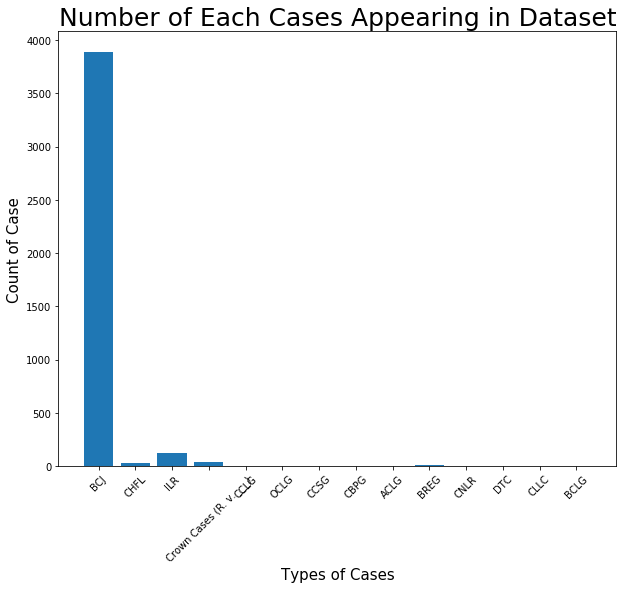

In [47]:

f1 = plt.figure(figsize=[10,8])
plt.bar(range(len(case_type_counts)), list(case_type_counts.values()), align='center')
plt.xticks(range(len(case_type_counts)), list(case_type_counts.keys()), rotation=45)
plt.ylabel('Count of Case', fontsize = '15' )
plt.xlabel('Types of Cases', fontsize = '15')
plt.title ('Number of Each Cases Appearing in Dataset', fontsize= '25')
plt.show()

In [88]:
path = "../data/Lexis Cases txt/"
list_of_files = os.listdir(path)


In [183]:
# list of dictionaries of attributes per document
all_cases_parsed =[]
for file in list_of_files:
    if file != ".DS_Store" and file != ".ipynb_checkpoints":
        all_cases_parsed.extend(rule_based_parse_BCJ(path + file, model, vectorizer))

In [184]:
all_cases_parsed[2] # first file (P1.txt), second case

{'case_number': '3 of 1',
 'case_title': 'Furness v. Guest, [2010] B.C.J. No. 1388',
 'year': '2010',
 'registry': 'Nanaimo',
 'judge': 'D.A. Halfyard J.',
 'decision_length': '97',
 'multiple_defendants': 'Y',
 'contributory_negligence_raised': True,
 'written_decision': True,
 'plaintiff_wins': 'Y',
 'damages': defaultdict(float,
             {'Future Care': None,
              'Future Wage Loss': 0,
              'General': None,
              'In Trust': 0,
              'Non Pecuniary': 40000.0,
              'Past Wage Loss': 0,
              'Punitive': None,
              'Special': 1020.7,
              'Aggravated': None,
              'Total': 41020.7,
              'Pecuniary Total': 1020.7}),
 'percent_reduction': 75.0,
 'contributory_negligence_successful': True}

In [185]:
df_all_cases = rule_based_convert_cases_to_DF(all_cases_parsed)
df_all_cases['Contributory Negligence Successful'].replace(np.nan, False, inplace = True)
df_all_cases.head()

,Case Number,Case Name,Year,Total Damage,Total Pecuniary,Non Pecuniary,General,Special,Punitive,Aggravated,Future Care,Judge Name,Decision Length,Multiple defendants?,Plaintiff Wins?,Contributory Negligence Raised,Written Decision?,Registry,Contributory Negligence Successful,Percent Reduction
0,1 of 1,"Mawani v. Pitcairn, [2012] B.C.J. No. 1819",2012,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,S.F. Kelleher J.,115,Y,Y,True,True,Vancouver,True,50.0
1,2 of 1,"Ediger (Guardian ad litem of) v. Johnston, [20...",2009,NaN,2964000.00,0.0,590000.0,424000.00,NaN,NaN,1950000.0,H.J. Holmes J.,350,N,Y,False,True,Vancouver,False,NaN
2,3 of 1,"Furness v. Guest, [2010] B.C.J. No. 1388",2010,41020.7,1020.70,0.0,NaN,1020.70,NaN,NaN,NaN,D.A. Halfyard J.,97,Y,Y,True,True,Nanaimo,True,75.0
3,4 of 1,"Howell v. Machi, [2017] B.C.J. No. 2016",2017,NaN,1803781.77,0.0,1775000.0,28781.77,NaN,1000.0,NaN,H. MacNaughton,525,Y,Y,True,True,Vancouver,True,25.0
4,5 of 1,"Morrow v. Outerbridge, [2009] B.C.J. No. 640",2009,NaN,290314.59,0.0,35000.0,255314.59,NaN,NaN,NaN,E.A. Bennett J.,311,Y,Y,False,True,Vancouver,False,NaN


In [186]:
df_all_cases.describe()

,Total Damage,Total Pecuniary,Non Pecuniary,General,Special,Punitive,Aggravated,Future Care,Percent Reduction
count,2.600000e+02,9.370000e+02,3852.0,5.930000e+02,8.100000e+02,33.000000,4.000000,5.300000e+02,328.000000
mean,4.796176e+05,2.235853e+05,0.0,1.795327e+05,4.931320e+04,13615.454545,4000.000000,1.190430e+05,42.324390
std,7.838862e+05,4.774079e+05,0.0,2.888989e+05,8.499230e+04,17359.648090,4062.019202,4.230457e+05,23.099538
min,4.500000e+03,1.000000e+00,0.0,1.000000e+02,1.000000e+00,1000.000000,1000.000000,7.500000e+01,5.000000
25%,9.871186e+04,1.800000e+04,0.0,2.500000e+04,4.548688e+03,5000.000000,2125.000000,5.000000e+03,25.000000
50%,2.548290e+05,7.221971e+04,0.0,7.500000e+04,1.747294e+04,10000.000000,2500.000000,1.981733e+04,40.000000
75%,5.392182e+05,2.316657e+05,0.0,2.000000e+05,5.937118e+04,15000.000000,4375.000000,6.718453e+04,60.000000
max,7.003618e+06,5.866412e+06,0.0,2.450000e+06,1.212527e+06,100000.000000,10000.000000,5.271100e+06,90.000000


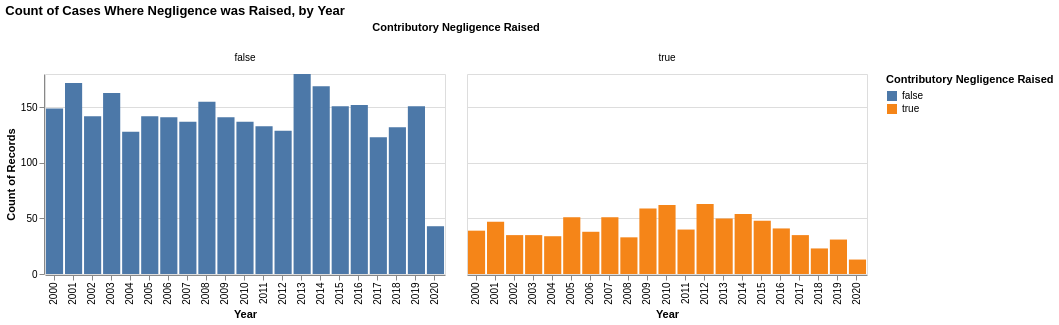

In [177]:
brush = alt.selection(type='interval', encodings=['x'])

raised = alt.Chart(df_all_cases).mark_bar().encode(
    alt.X('Year:O', scale=alt.Scale(domain=brush)),
#     x=,
    y='count(Contributory Negligence Raised):Q',
    color=alt.condition(brush, 'Contributory Negligence Raised:N', alt.value('lightgray')),
#     color='contributory_negligence_raised:N',
    column = 'Contributory Negligence Raised:N'
).properties(
    title='Count of Cases Where Negligence was Raised, by Year', width=400,
    height=200).add_selection(brush)
raised

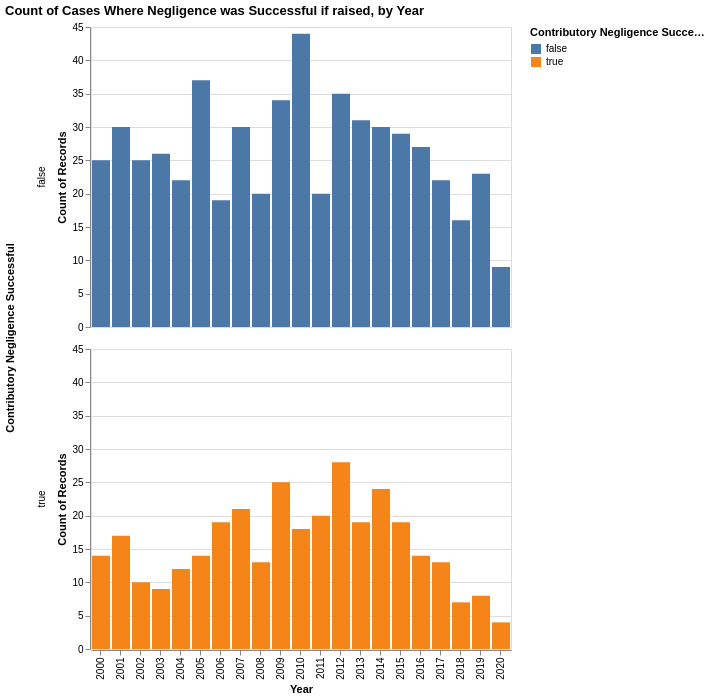

In [123]:
success = alt.Chart(df_all_cases[df_all_cases['Contributory Negligence Raised']==True]).mark_bar().encode(
    alt.X('Year:O', scale=alt.Scale(domain=brush)),
    y='count(Contributory Negligence Successful):Q',
    color=alt.condition(brush, 'Contributory Negligence Successful:N', alt.value('lightgray')),
    row = 'Contributory Negligence Successful:N'
).properties(title='Count of Cases Where Negligence was Successful if raised, by Year'
    ).add_selection(brush)
success

Text(0.5, 1.0, 'Median Total Damage per year')

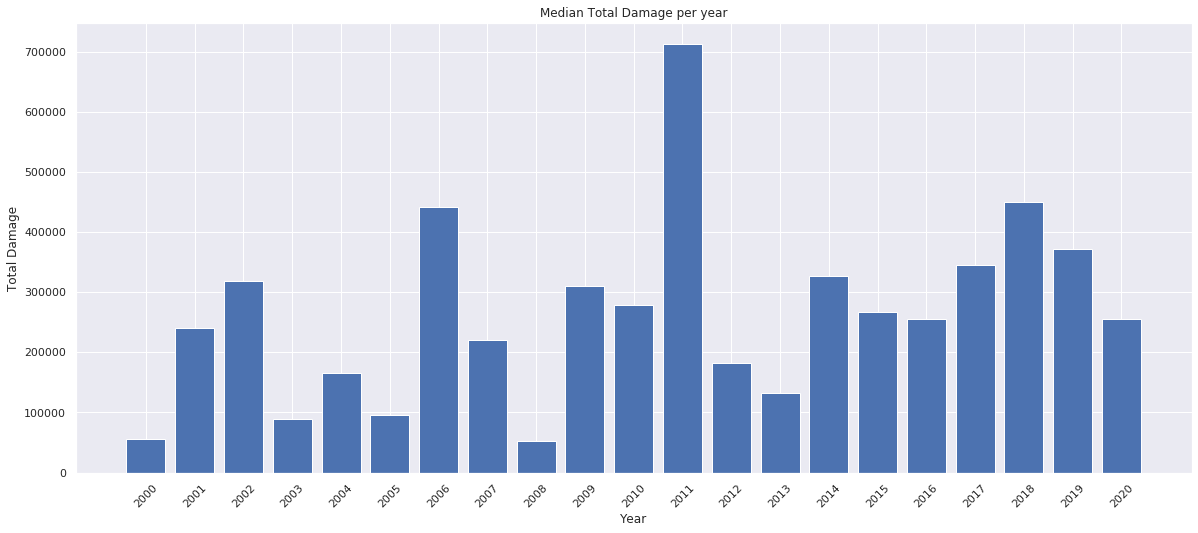

In [187]:
df_grouped = df_all_cases.groupby('Year').median()
plt.bar(df_grouped.index, df_grouped['Total Damage'])
plt.xlabel('Year')
plt.ylabel('Total Damage')
plt.xticks(rotation=45)
plt.title('Median Total Damage per year')

/home/ilana/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:834: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ilana/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:835: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Total Damage (CAD)')

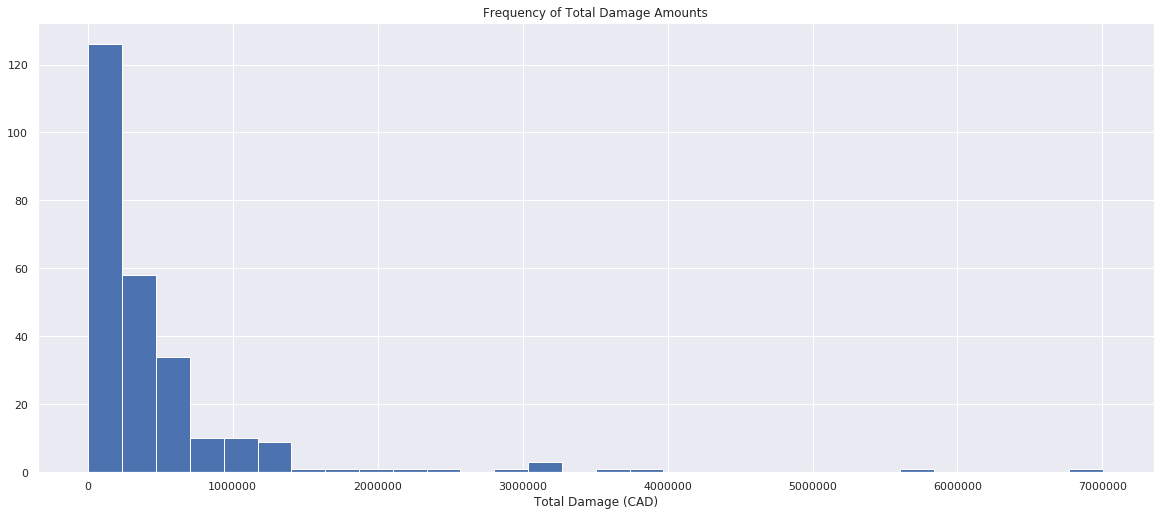

In [190]:
plt.hist('Total Damage', data = df_all_cases, bins = 30)
plt.title("Frequency of Total Damage Amounts") 
plt.xlabel('Total Damage (CAD)')

In [198]:
df_filtered = df_all_cases[df_all_cases['Total Damage'] < 6.00000000e+06] #removed outliers above 6 million


In [199]:
df_filtered.describe()

,Total Damage,Total Pecuniary,Non Pecuniary,General,Special,Punitive,Aggravated,Future Care,Percent Reduction
count,2.590000e+02,2.330000e+02,259.0,1.730000e+02,2.260000e+02,1.0,1.0,1.730000e+02,48.000000
mean,4.544285e+05,2.983510e+05,0.0,2.126112e+05,6.334099e+04,5000.0,2500.0,1.064680e+05,37.979167
std,6.717522e+05,5.445878e+05,0.0,2.654121e+05,1.048810e+05,NaN,NaN,4.041054e+05,21.978219
min,4.500000e+03,1.600000e+02,0.0,2.500000e+03,6.000000e+01,5000.0,2500.0,1.662500e+02,10.000000
25%,9.871097e+04,4.359925e+04,0.0,5.000000e+04,8.177300e+03,5000.0,2500.0,5.000000e+03,20.000000
50%,2.526210e+05,1.564821e+05,0.0,1.113000e+05,2.727157e+04,5000.0,2500.0,2.300000e+04,31.500000
75%,5.293065e+05,3.300000e+05,0.0,2.800000e+05,8.261506e+04,5000.0,2500.0,7.000000e+04,50.000000
max,5.647773e+06,5.866412e+06,0.0,1.500000e+06,1.212527e+06,5000.0,2500.0,4.151504e+06,85.000000


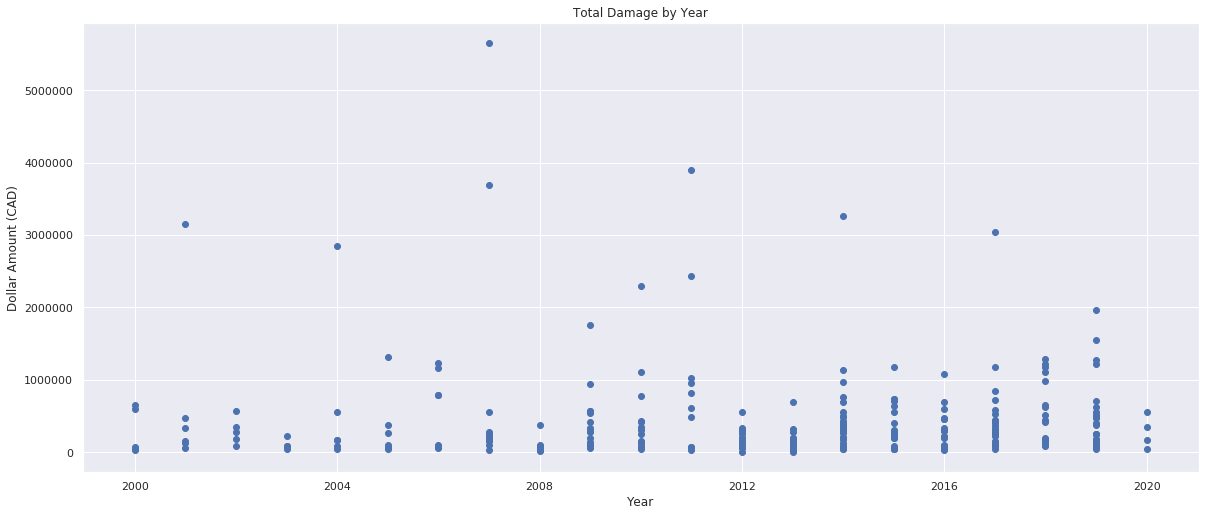

In [193]:
plt.title("Total Damage by Year")
plt.xlabel('Year')
plt.ylabel('Dollar Amount (CAD)')
plt.scatter('Year', 'Total Damage', data=df_filtered.sort_values(by='Year'))

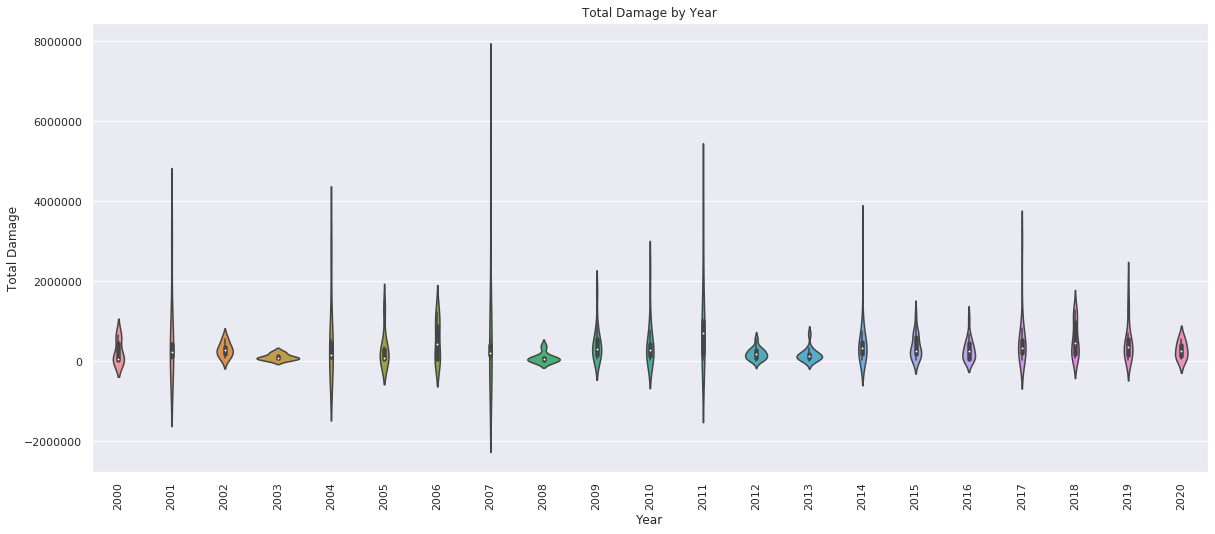

In [202]:
plt.title("Total Damage by Year")
plt.xticks(rotation=90)


sns.violinplot('Year','Total Damage', data = df_filtered.sort_values(by='Year'))

### Filter for Judges with Over 20 Cases

Text(0.5, 1.0, 'Total Damage per Judge with Over 20 Cases')

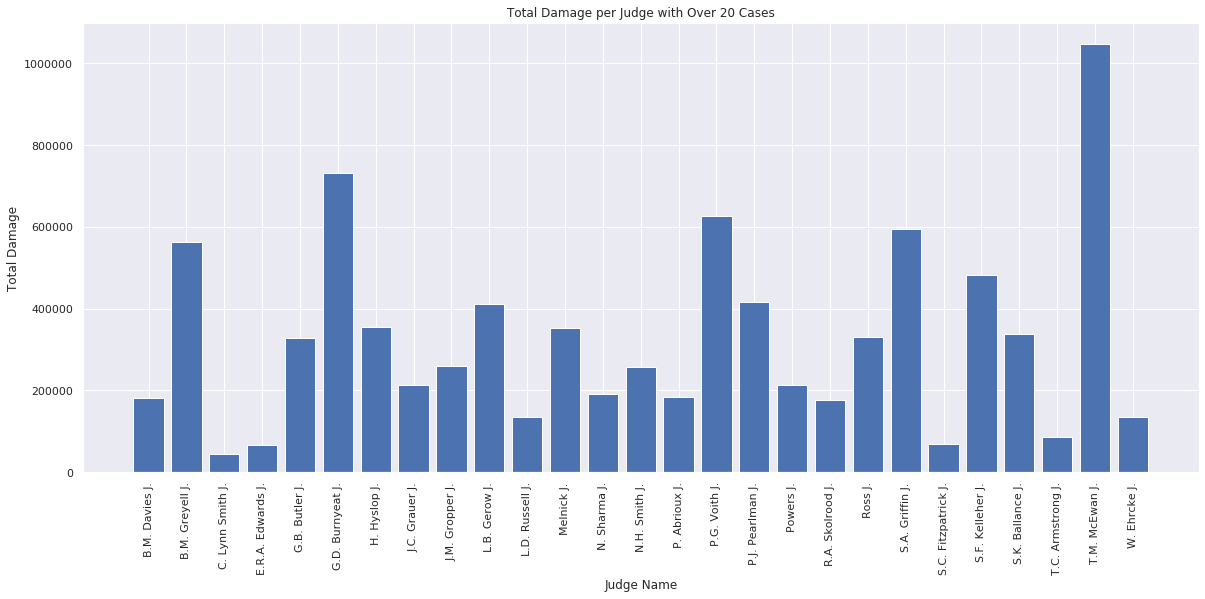

In [220]:
filtered = df_all_cases['Judge Name'].value_counts() > 20
filtered = filtered.reset_index()
judges = filtered[filtered['Judge Name'] == True]['index'].values # judges with over 20 cases
df_filtered = df_filtered[df_filtered['Judge Name'].isin(judges)]

plt.xticks(rotation=90)
df_grouped = df_filtered.groupby('Judge Name').median()
plt.bar(df_grouped.index, df_grouped['Total Damage'])
plt.xlabel('Judge Name')
plt.ylabel('Total Damage')
plt.title('Total Damage per Judge with Over 20 Cases')

In [103]:
mult_def = []
years = []
judge_names =[]
case_names = []
for d in all_cases_parsed:
    for keys , values in d.items():
        if keys == 'multiple_defendants':
            mult_def.append(values)
        if keys == 'year':
            years.append(values)
        if keys == 'judge':
            judge_names.append(values)
        if keys == "case_title":
            case_names.append(values)

In [54]:
df = pd.DataFrame({'multiple_defendants':mult_def})

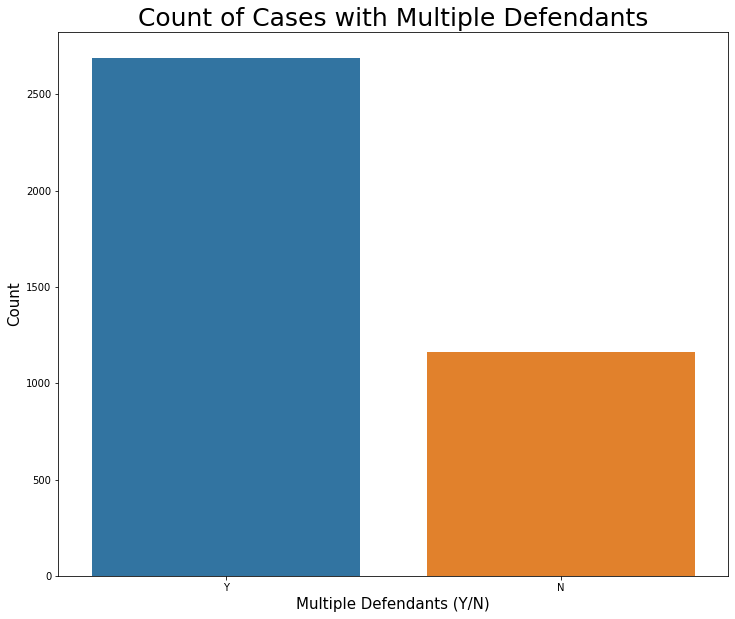

In [55]:
f1 = plt.figure(figsize=[12,10])
ax = sns.countplot(x="multiple_defendants", data=df)
plt.ylabel('Count', fontsize = '15' )
plt.xlabel('Multiple Defendants (Y/N)', fontsize = '15')
plt.title ('Count of Cases with Multiple Defendants', fontsize= '25')
plt.show()

## Evaluate Classifier Results on Total Damage Only - If no Total From Classifier, Total set to None

In [238]:
gold = pd.read_excel('../data/annotations/Case-Annotation.xlsx')
gold.dropna(how = 'all', inplace=True) 
gold['Contributory Negligence Successful?'].replace(np.nan, 'N', inplace = True)
gold.head()

,Case Number,Case Name,Written Decision?,Plaintiff Wins?,Multiple defendants?,Judge Name,Decision Length: paragraphs),Registry,$ Damages total before contributory negligence,$ Non-Pecuniary Damages,...,Future Care Costs (General Damages),$ General Damages,$ Punitive Damages,$Aggravated Damages,Contributory Negligence Raised?,Contributory Negligence Successful?,% Reduction as a result of contributory negligence,$ Reduction as a result of contributory negligence,$ Final Award after contributory negligence,Unnamed: 21
0,1 of 1,"Mawani v. Pitcairn, [2012] B.C.J. No. 1819",Y,Y,Y,Kelleher J,115.0,Vancouver,NaN,NaN,...,NaN,NaN,NaN,NaN,y,Y,50.0,NaN,NaN,NaN
1,51 of 2,"Morrow v. Outerbridge, 2009 CHFL para. 15,554",N,Y,NaN,Bennett J,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN
2,101 of 3,"Brooks-Martin v. Martin, [2011] B.C.J. No. 243",Y,Y,Y,Halfyard J.,172.0,Nanaimo,NaN,NaN,...,NaN,NaN,NaN,NaN,y,Y,30.0,NaN,NaN,NaN
3,151 of 4,"R. v. Tremblay, [2013] B.C.J. No. 959",Y,Y,NaN,Butler J,164.0,Vancouver,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN
4,201 of 5,"Mclaren v. Rice, [2009] B.C.J. No. 2108",Y,Y,Y,Brooke J,46.0,Vancouver,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN


In [234]:
df_all_cases['Contributory Negligence Successful'].replace(True, 'Y', inplace=True)
df_all_cases['Contributory Negligence Successful'].replace(False, 'N', inplace= True)

In [239]:
import math
evaluate(df_all_cases, gold)

#### Evaluation ####


/home/ilana/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


-------
COLUMN: Case Number
Filled field accuracy: 23.96694214876033 % 29 / 121
Overall accuracy: 23.96694214876033 % 29 / 121
-------
COLUMN: Case Name
Filled field accuracy: 100.0 % 121 / 121
Overall accuracy: 100.0 % 121 / 121
-------
COLUMN: $ Damages total before contributory negligence
Average distance from correct answer: $67166.66666666664
Empty field accuracy: 95.23809523809523 % 20 / 21
Filled field accuracy: 46.0 % 46 / 100
Overall accuracy: 54.54545454545454 % 66 / 121
-------
COLUMN: $ Pecuniary Damages Total
Average distance from correct answer: $102779.81695652174
Empty field accuracy: 100.0 % 2 / 2
Filled field accuracy: 45.378151260504204 % 54 / 119
Overall accuracy: 46.28099173553719 % 56 / 121
-------
COLUMN: $ Non-Pecuniary Damages
Average distance from correct answer: $41210.74380165289
Empty field accuracy: 0.0 % 0 / 54
Filled field accuracy: 0.0 % 0 / 67
Overall accuracy: 0.0 % 0 / 121
-------
COLUMN: $ General Damages
Average distance from correct answer: $87258